In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.activations import tanh, elu, relu
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence

import os
from scipy import signal
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py

!cp '/content/drive/MyDrive/ML/ExportNNM.py' /content/

import ExportNNM
from importlib import reload

In [ ]:
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()

def HiPass(x, coeff=0.85):
    return tf.concat([x[:, 0:1, :], x[:, 1:, :] - coeff * x[:, :-1, :]], axis=1)

def LowPass(x, coeff=0.85):
    return tf.concat([x[:, 0:1, :], x[:, 1:, :] + coeff * x[:, :-1, :]], axis=1)

def esr_loss_with_frequency(target_y, predicted_y):
    return mae(HiPass(target_y), HiPass(predicted_y))

def esr_loss(target_y, predicted_y):
    return mae(target_y, predicted_y)

def error_to_signal(y_true, y_pred): 
    """
    Error to signal ratio with pre-emphasis filter:
    """
    y_true, y_pred = HiPass(y_true), HiPass(y_pred)
    return K.sum(tf.pow(y_true - y_pred, 2), axis=0) / (K.sum(tf.pow(y_true, 2), axis=0) + 1e-10)

def save_wav(name, data, fs = 44100):
    wavfile.write(name, fs, data.flatten().astype(np.float32))

def normalize(data):
    data_max = max(data)
    data_min = min(data)
    data_norm = max(data_max,abs(data_min))
    return data / data_norm

In [ ]:
# EDIT THIS SECTION FOR USER INPUTS
#
name = '1959HW_V1-4_V2-2'
in_file = '/content/drive/MyDrive/ML/NAM_1959HW/v1_1_1.wav'
out_file = '/content/drive/MyDrive/ML/NAM_1959HW/output/1959HW_V1-4_V2-2.wav'

if not os.path.exists('models/'+name):
    os.makedirs('models/'+name)
else:
    print("A model with the same name already exists. Please choose a new name.")
    exit

# Load and Preprocess Data ###########################################
in_rate, in_data = wavfile.read(in_file)
out_rate, out_data = wavfile.read(out_file)

#offset = 5 * in_rate
offset = 56228
x_all = in_data.astype(np.float32).flatten()
x_all = x_all[offset:]  
x_all = normalize(x_all).reshape(len(x_all),1)   
y_all = out_data.astype(np.float32).flatten() 
#y_all = y_all[offset-2:]
y_all = y_all[offset:]
y_all = normalize(y_all).reshape(len(y_all),1)    

<ipython-input-8-b67c418dab06>:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  out_rate, out_data = wavfile.read(out_file)


In [ ]:
def linear_2_db(signal):
    return 20.0 * np.log10(signal)


def db_2_linear(signal_db):
    return 10.0 ** (signal_db / 20.0)


def normalize_max_peak(signal):
    data_max = np.max(np.abs(signal))
    return signal / data_max


def normalize_at_minus_3dB(signal):
    data_max = np.max(np.abs(signal))
    minus_3db_in_linear = 0.707
    return signal * (minus_3db_in_linear / data_max)


def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]


def get_data_in_interval(data, from_sample, to_sample):
    new_data = data[from_sample:to_sample]
    return new_data


def remove_data_in_interval(data, from_sample, to_sample):
    new_data1 = data[:from_sample]
    new_data2 = data[to_sample:]
    new_data = np.concatenate([new_data1, new_data2])
    return new_data


def calculate_rms(signal):
    rms = np.sqrt(np.mean(signal ** 2))
    return rms


def calculate_rms_db(signal):
    rms = calculate_rms(signal)
    rms_db = linear_2_db(rms)
    return rms_db


def calculate_peak_db(signal):
    data_max = np.max(np.abs(signal))
    peak_db = linear_2_db(data_max)
    return peak_db


def FilterSignal(data, order=8, sample_rate=44100.0, cutoff=15000, type='low'):
    nyq_freq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq_freq
    b, a = butter(order, normal_cutoff, btype=type, analog=False)
    y = filtfilt(b, a, data)
    return y


def partition_data(input_data, output_data, sequence_length, trainTestRatio=0.7, overlap=2048):
    input = normalize_max_peak(input_data)
    output = normalize_at_minus_3dB(output_data)
    numSamples = np.minimum(input.shape[0], output.shape[0])
    
    reshapedInput = []
    reshapedOutput = []
    num_batches = math.floor((numSamples - sequence_length) / overlap)
    
    for i in range(0, num_batches):
        start = i * overlap
        end = start + sequence_length
        tempInputArray = input[start:end]
        tempOutputArray = output[start:end]
        reshapedInput.append(np.array(tempInputArray))
        reshapedOutput.append(np.array(tempOutputArray))

    train_length = math.floor(num_batches * trainTestRatio)
    input_train = np.array(reshapedInput[:train_length])
    output_train = np.array(reshapedOutput[:train_length])
    input_test = np.array(reshapedInput[train_length:])
    output_test = np.array(reshapedOutput[train_length:])

    return (input_train, output_train, input_test, output_test)

In [ ]:
train_size = 0.8

epochs = 8
num_steps = 2048
overlap = 256
batch_size = 64 
learning_rate = 0.008
epsilon = 1.e-08
hidden_units = 16

# Create Sequential Model ###########################################
clear_session()

model = Sequential()

model.add(InputLayer(input_shape=(None, 1)))

useD1 = True
useC1 = True
useC2 = True

if useD1:
  model.add(Dense(units=1, use_bias=False,
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=None),
    bias_initializer='zeros',
    activation='tanh',
    name='D1'))

if useC2:
  conv_init = np.zeros(128)
  conv_init[0] = 1.0
  model.add(Conv1D(filters=1, kernel_size=128,
    padding='causal',
    bias_initializer='zeros',
    kernel_initializer=tf.constant_initializer(conv_init),
    use_bias=False,
    name='C1'))

model.add(LSTM(name='L', units=hidden_units,
  stateful=False,
  bias_initializer='zeros',
  kernel_initializer=tf.keras.initializers.GlorotUniform(seed=None),
  recurrent_initializer=tf.keras.initializers.Orthogonal(seed=None),
  return_sequences=True))

model.add(Dense(units=1,
  kernel_initializer=tf.keras.initializers.GlorotUniform(seed=None),
  bias_initializer='zeros',
  name='D2'))

if useC2:
  conv_init = np.zeros(2048)
  conv_init[0] = 1.0
  model.add(Conv1D(filters=1, kernel_size=2048,
    padding='causal',
    bias_initializer='zeros',
    kernel_initializer=tf.constant_initializer(conv_init),
    use_bias=False,
    name='C2'))

#model.compile(optimizer=Adam(learning_rate=learning_rate, epsilon=epsilon), loss=error_to_signal, metrics='mse')
#model.compile(optimizer=Adam(learning_rate=learning_rate, epsilon=epsilon), loss=esr_loss_with_frequency, metrics='mse')
#model.compile(optimizer=Adam(learning_rate=learning_rate, epsilon=epsilon), loss=esr_loss, metrics='mse')
model.compile(optimizer=Adam(learning_rate=learning_rate, epsilon=epsilon), loss='mae', metrics='mse')
#model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv1D)                 (None, None, 1)           128       
                                                                 
 L (LSTM)                    (None, None, 16)          1152      
                                                                 
 D2 (Dense)                  (None, None, 1)           17        
                                                                 
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train, y_train, x_test, y_test = partition_data(x_all,y_all,num_steps,train_size,overlap)

train_observations = int(x_train.shape[0] / batch_size) * batch_size
test_observations = int(x_test.shape[0] / batch_size) * batch_size
x_train = x_train[:train_observations]
y_train = y_train[:train_observations]
x_test = x_test[:test_observations]
y_test = y_test[:test_observations]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

In [ ]:
epochs = 10
#K.set_value(model.optimizer.learning_rate, 0.01)

In [ ]:
def scheduler(epoch, lr):
    if 0 < epoch < 12:
        return lr * 0.95
    return lr

scheduler_clbk = tf.keras.callbacks.LearningRateScheduler(scheduler)
plateu_clbk = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
earlystop_clbk = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(x=x_train,y=y_train, validation_data=(x_test, y_test), epochs=epochs, callbacks=[scheduler_clbk, plateu_clbk, earlystop_clbk], shuffle=True)

model.save('/content/drive/MyDrive/ML/NAM_1959HW/output/'+name+'/'+name+'.h5')
model.save('/content/drive/MyDrive/ML/NAM_1959HW/output/'+name+'/'+name+'_data.h5',include_optimizer=False)

Epoch 1/8
832/832 [==============================] - 57s 54ms/step - loss: 0.0836 - mse: 0.0160 - val_loss: 0.0303 - val_mse: 0.0026 - lr: 0.0080
Epoch 2/8
832/832 [==============================] - 40s 49ms/step - loss: 0.0590 - mse: 0.0092 - val_loss: 0.0268 - val_mse: 0.0021 - lr: 0.0076
Epoch 3/8
832/832 [==============================] - 39s 47ms/step - loss: 0.0527 - mse: 0.0075 - val_loss: 0.0234 - val_mse: 0.0018 - lr: 0.0072
Epoch 4/8
832/832 [==============================] - 39s 47ms/step - loss: 0.0500 - mse: 0.0068 - val_loss: 0.0226 - val_mse: 0.0016 - lr: 0.0069
Epoch 5/8
832/832 [==============================] - 39s 47ms/step - loss: 0.0489 - mse: 0.0066 - val_loss: 0.0230 - val_mse: 0.0016 - lr: 0.0065
Epoch 6/8
832/832 [==============================] - 39s 47ms/step - loss: 0.0475 - mse: 0.0063 - val_loss: 0.0226 - val_mse: 0.0016 - lr: 0.0062
Epoch 7/8
832/832 [==============================] - 39s 47ms/step - loss: 0.0471 - mse: 0.0061 - val_loss: 0.0224 - val_mse

In [ ]:
train_size=0.8

In [ ]:
model.save('models/'+name+'/'+name+'.h5')

# Run Prediction #################################################
print("Running prediction..")

y_the_rest, y_last_part = np.split(y_all, [int(len(y_all)*train_size)])
x_the_rest, x_last_part = np.split(x_all, [int(len(x_all)*train_size)])

prediction = model.predict(x_last_part)

save_wav('models/'+name+'/y_pred.wav', prediction)
save_wav('models/'+name+'/x_test.wav', x_last_part)
save_wav('models/'+name+'/y_test.wav', y_last_part)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/ML/NAM_1959HW/output/test/test_data.h5')

In [ ]:
save_wav('models/'+name+'/y_train.wav', y_last_part)

(16780, 2048, 1)

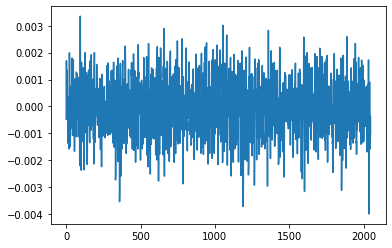

In [ ]:
plt.plot(y_train[0].flatten())

In [ ]:
clear_session()
model = tf.keras.models.load_model('models/my_model.h5')

In [ ]:
reload(ExportNNM)
from ExportNNM import *

export_model_to_nnm('/content/drive/MyDrive/ML/NAM_1959HW/output/'+name+'/'+name+'.nnm',1,0,model,1)
export_model_to_nnm('models/'+name+'/'+name+'.nnm',1,0,model,1)

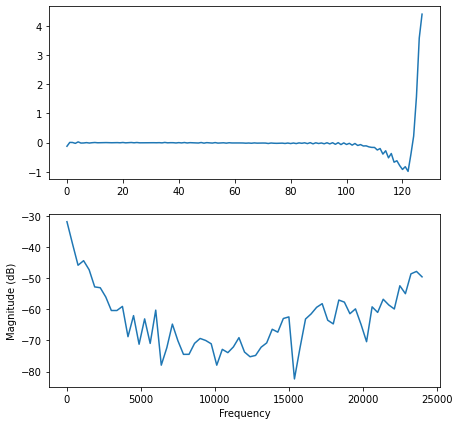

In [ ]:
c1 = model.layers[0].get_weights()[0].flatten()

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
axs[0].plot(c1);
axs[1].magnitude_spectrum(c1, in_rate, scale='dB');

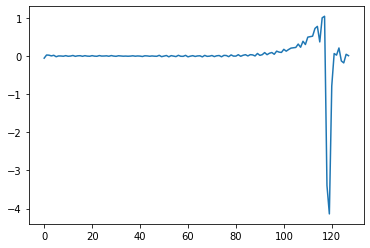

In [ ]:
plt.plot(c1);

In [ ]:
def BlockSize(n):
  return 2**math.ceil(math.log2(n))

def MPT(x, q = 8):
  l = x.size
  bs = BlockSize(q * l)
  hbs = int(bs/2)
  Hk = np.fft.fft(np.pad(x,bs))
  cn = np.fft.ifft(np.log(np.abs(Hk)))
  cn[1:hbs-1] *= 2
  cn[hbs+1:] = 0
  return np.fft.ifft(np.exp(np.fft.fft(cn)))[:l]

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


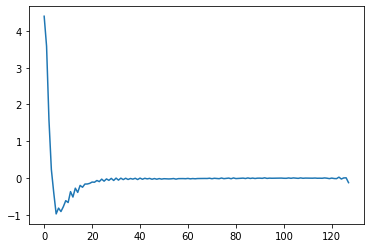

In [ ]:
plt.plot(MPT(c1));